In [7]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso

In [75]:
food = pd.read_csv('../../data/nu3-pctfoodsupply-CO2-emissions.csv').drop(columns='Unnamed: 0')
food2 = food.drop(columns='Country')
food2.head()

,porksupply_pct,chickensupply_pct,beefsupply_pct,lambsupply_pct,fishsupply_pct,eggsupply_pct,milkcheesesupply_pct,wheatprodsupply_pct,ricesupply_pct,soybeansupply_pct,nutssupply_pct,totalco2
0,0.024475,0.090031,0.129201,0.003633,0.010153,0.026525,0.454298,0.240120,0.020423,0.000000,0.001141,2172.40
1,0.051904,0.099164,0.072803,0.021222,0.038036,0.018298,0.504182,0.151498,0.023716,0.000409,0.018771,1938.64
2,0.020423,0.024834,0.042235,0.028758,0.007227,0.023370,0.570120,0.260244,0.014604,0.000000,0.008184,1777.84
3,0.045923,0.056891,0.028287,0.044716,0.157545,0.017446,0.478118,0.154390,0.008236,0.000233,0.008215,1731.35
4,0.061759,0.096919,0.062313,0.052394,0.056411,0.027458,0.380278,0.213094,0.025380,0.001219,0.022775,1750.94


In [48]:
food[food['Country'] == 'USA']

,porksupply_pct,chickensupply_pct,beefsupply_pct,lambsupply_pct,fishsupply_pct,eggsupply_pct,milkcheesesupply_pct,wheatprodsupply_pct,ricesupply_pct,soybeansupply_pct,nutssupply_pct,totalco2,Country
5,0.056276,0.101822,0.073786,0.000875,0.025145,0.029685,0.518558,0.163759,0.014008,0.000081,0.016003,1718.86,USA


## Model Definition

In [11]:
def define_lm(Model, alpha=0):
    if Model == LinearRegression:
        return Model()
    else:
        return Model(alpha=alpha)

## ML Model Data Pipeline

Given a dataset, y variable column name, and a model, do the following:  
1. Split the data into training and testing data
2. Train the model on the training set, and predict on the test set.
3. Calculate the MSE, and plot some diagnostics.

In [49]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.nonparametric.smoothers_lowess import lowess
import numpy as np
import scipy.stats as stats

In [80]:
# run the test harness for evaluating a model
def run_model_pipeline(data, y_col, model, test_size=0.2, random_state=100, diagnostics = False):

    print('Splitting data...')
    X = data.loc[:, data.columns != y_col]
    y = data[y_col]
    X_train, X_test, y_train, y_test = train_test_split(X, y, \
                                                        test_size=test_size, \
                                                        random_state=random_state)
    # fit model with scikit-learn
    print('Fitting Model...')
    model.fit(X_train, y_train)

    # evaluate model
    preds = results.predict(X_test)
    mse = mean_squared_error(preds, y_test.values)
    print('[MSE:', str(np.round(mse, 4)), ']')
    
    r_2 = model.score(X_test, y_test)
    print('[R^2:', str(r_2), ']')
    
    # need to fix
    if diagnostics:
        summarize_diagnostics(preds, y_test)

    print('----FINISHED----')
    
    return model

# plot diagnostic learning curves
def summarize_diagnostics(preds, y_test):

    # plot residuals
    plt.subplot(211)
    plt.title('Fitted Values vs. Residuals')
    plt.plot(preds, y_test - model.predict(X_test), color='blue')
    plt.ylabel('Residual')
    plt.xlabel('Fitted Values')
    plt.legend()

    # save plot to file
#     plt.savefig('../../visualizations/diagnostic_plot_vl.png')
#     plt.close()

---

In [68]:
# code from here: https://towardsdatascience.com/going-from-r-to-python-linear-regression-diagnostic-plots-144d1c4aa5a

def plot_residuals_vs_fitted(results):
    '''
    Given a fitted statsmodels.OLS model, graph the residuals vs. fitted data. Code taken from link above.
    '''
    residuals = results.resid
    fitted = results.fittedvalues
    smoothed = lowess(residuals,fitted)
    top3 = abs(residuals).sort_values(ascending = False)[:3]

    plt.rcParams.update({'font.size': 16})
    plt.rcParams["figure.figsize"] = (8,7)
    fig, ax = plt.subplots()
    ax.scatter(fitted, residuals, edgecolors = 'k', facecolors = 'none')
    ax.plot(smoothed[:,0],smoothed[:,1],color = 'r')
    ax.set_ylabel('Residuals')
    ax.set_xlabel('Fitted Values')
    ax.set_title('Residuals vs. Fitted')
    ax.plot([min(fitted),max(fitted)],[0,0],color = 'k',linestyle = ':', alpha = .3)

    for i in top3.index:
        ax.annotate(i,xy=(fitted[i],residuals[i]))

In [69]:
def qqplot(results):
    '''
    Given a fitted statsmodels.OLS model, graph the normal Q-Q plot. Code taken from link above.
    '''
    sorted_student_residuals = pd.Series(results.get_influence().resid_studentized_internal)
    sorted_student_residuals.index = results.resid.index
    sorted_student_residuals = sorted_student_residuals.sort_values(ascending = True)
    df = pd.DataFrame(sorted_student_residuals)
    df.columns = ['sorted_student_residuals']
    df['theoretical_quantiles'] = stats.probplot(df['sorted_student_residuals'], dist = 'norm', fit = False)[0]
    rankings = abs(df['sorted_student_residuals']).sort_values(ascending = False)
    top3 = rankings[:3]

    fig, ax = plt.subplots()
    x = df['theoretical_quantiles']
    y = df['sorted_student_residuals']
    ax.scatter(x,y, edgecolor = 'k',facecolor = 'none')
    ax.set_title('Normal Q-Q')
    ax.set_ylabel('Standardized Residuals')
    ax.set_xlabel('Theoretical Quantiles')
    ax.plot([np.min([x,y]),np.max([x,y])],[np.min([x,y]),np.max([x,y])], color = 'r', ls = '--')
    for val in top3.index:
        ax.annotate(val,xy=(df['theoretical_quantiles'].loc[val],df['sorted_student_residuals'].loc[val]))
    plt.show()

In [73]:
def plot_leverage(results):
    '''
    Given a fitted statsmodels.OLS model, graph the residuals vs. leverage plot. Code taken from link above.
    '''
    student_residuals = pd.Series(results.get_influence().resid_studentized_internal)
    student_residuals.index = results.resid.index
    df = pd.DataFrame(student_residuals)
    df.columns = ['student_residuals']
    df['leverage'] = results.get_influence().hat_matrix_diag
    smoothed = lowess(df['student_residuals'],df['leverage'])
    sorted_student_residuals = abs(df['student_residuals']).sort_values(ascending = False)
    top3 = sorted_student_residuals[:3]

    fig, ax = plt.subplots()
    x = df['leverage']
    y = df['student_residuals']
    xpos = max(x)+max(x)*0.01  
    ax.scatter(x, y, edgecolors = 'k', facecolors = 'none')
    ax.plot(smoothed[:,0],smoothed[:,1],color = 'r')
    ax.set_ylabel('Studentized Residuals')
    ax.set_xlabel('Leverage')
    ax.set_title('Residuals vs. Leverage')
    ax.set_ylim(min(y)-min(y)*0.15,max(y)+max(y)*0.15)
    ax.set_xlim(-0.01,max(x)+max(x)*0.05)
    plt.tight_layout()
    for val in top3.index:
        ax.annotate(val,xy=(x.loc[val],y.loc[val]))

    cooksx = np.linspace(min(x), xpos, 50)
    p = len(results.params)
    poscooks1y = np.sqrt((p*(1-cooksx))/cooksx)
    poscooks05y = np.sqrt(0.5*(p*(1-cooksx))/cooksx)
    negcooks1y = -np.sqrt((p*(1-cooksx))/cooksx)
    negcooks05y = -np.sqrt(0.5*(p*(1-cooksx))/cooksx)

    ax.plot(cooksx,poscooks1y,label = "Cook's Distance", ls = ':', color = 'r')
    ax.plot(cooksx,poscooks05y, ls = ':', color = 'r')
    ax.plot(cooksx,negcooks1y, ls = ':', color = 'r')
    ax.plot(cooksx,negcooks05y, ls = ':', color = 'r')
    ax.plot([0,0],ax.get_ylim(), ls=":", alpha = .3, color = 'k')
    ax.plot(ax.get_xlim(), [0,0], ls=":", alpha = .3, color = 'k')
    ax.annotate('1.0', xy = (xpos, poscooks1y[-1]), color = 'r')
    ax.annotate('0.5', xy = (xpos, poscooks05y[-1]), color = 'r')
    ax.annotate('1.0', xy = (xpos, negcooks1y[-1]), color = 'r')
    ax.annotate('0.5', xy = (xpos, negcooks05y[-1]), color = 'r')
    ax.legend()
    plt.show()

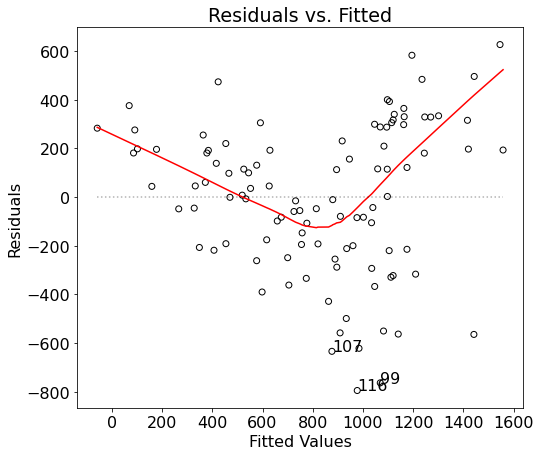

In [70]:
plot_residuals_vs_fitted(results)

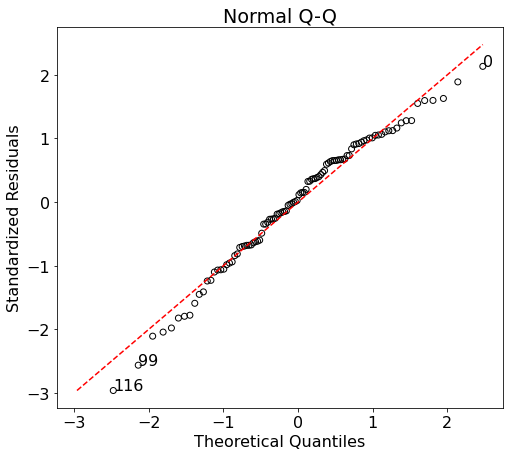

In [71]:
qqplot(results)

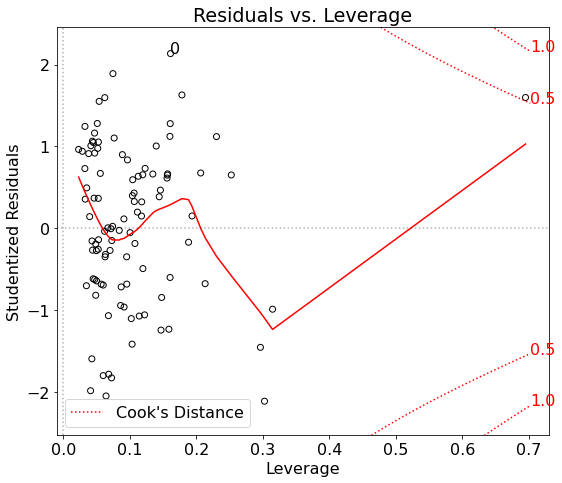

In [74]:
plot_leverage(results)

No handles with labels found to put in legend.


Splitting data...
Fitting Model...
[MSE: 13929888.5526 ]
[R^2: 0.41471900924150895 ]
----FINISHED----


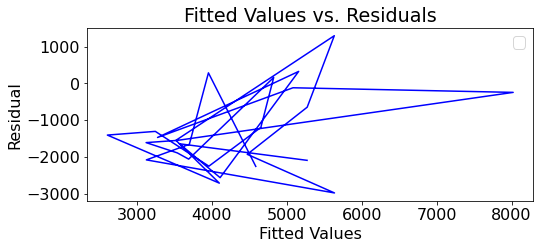

In [81]:
model = define_lm(LinearRegression)
fittedmodel = run_model_pipeline(food2, 'totalco2', model, diagnostics=True)

In [ ]:
X = sm.add_constant(food2.loc[:, food2.columns != 'totalco2']).drop(columns='soybeansupply_pct')
y = food2['totalco2']

X_train, X_test, y_train, y_test = train_test_split(X, y, \
                                                        test_size=0.2, \
                                                        random_state=100)

model = sm.OLS(y_train, X_train)
results = model.fit()